# UK Biobank organ aging training and testing

Dataframes are not shown because UKB data cannot be shown.

In [1]:
import sys
import site
sys.path.append(site.USER_SITE)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import re
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.multitest import multipletests
import math
from adjustText import adjust_text
import json
import mygene
import itertools
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import time
import networkx as nx
import os
import pickle
import random

sns.set(style="ticks", font="Open Sans")

%matplotlib inline



In [2]:
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42

In [3]:
with open("../data/dictionaries/COLORMAP_gtex_tissues.json") as fp:
    colormap_dict = json.load(fp)
with open("../data_ukb/Olink_3k_tissue_plist_dict.json") as fp:
    tissue_plist_dict = json.load(fp)
    

# Aging models

In [24]:
with open("../data_ukb/Olink_3k_tissue_plist_dict_revision_240829.json") as fp:
    tissue_plist_dict = json.load(fp)
        

In [25]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso


def Plot_and_pick_alpha(model, performance_CUTOFF, plot=True):
    
    #pick alpha at 90-95% top performance, negative derivative (higher alpha)
    toplot=pd.DataFrame({"alphas":model.alphas_, "score":model.mse_path_.mean(axis=1)})
   # sns.scatterplot(x=model.alphas_, y=model.mse_path_.mean(axis=1))
   # plt.xscale("log")
   # plt.show()
    
    toplot["score_rev"]=-toplot["score"]
    toplot["score_rev_norm"] = NormalizeData(toplot["score_rev"])
    toplot["score_rev_norm_minus95"] = toplot["score_rev_norm"]-performance_CUTOFF
    toplot["score_rev_norm_minus95_abs"] = np.abs(toplot["score_rev_norm_minus95"])

    #derivative of performance by alpha
    x=toplot.alphas.to_numpy()
    y=toplot.score_rev_norm.to_numpy()
    #y=toplot.score.to_numpy()
    dx=0.0001
    toplot["derivative"] = np.gradient(y, dx)
    tmp=toplot.loc[toplot.derivative>0]
    #print(tmp)
    if len(tmp)!=0:
        best_alpha = list(tmp.loc[tmp.score_rev_norm_minus95_abs == np.min(tmp.score_rev_norm_minus95_abs)].alphas)[0]
    else:
        print('no alpha with derivative <0')
        best_alpha = list(tmp.loc[tmp.score_rev_norm_minus95_abs == np.min(tmp.score_rev_norm_minus95_abs)].alphas)[0]
    print(best_alpha)
    
    
    #PLOT
    fig,axs=plt.subplots(figsize=(4,3))    
    g = plt.plot(toplot.alphas, toplot.score_rev_norm, label="scores")
    #g = plt.plot(toplot.alphas, toplot.derivative, label="derivative")
    plt.xlabel("alpha")
    plt.ylabel("normalized score")
    plt.title("LassoCV Alapha Error")
    plt.xscale("log")
    plt.axhline(0.95)
    plt.axvline(model.alpha_, color="black")
    plt.axvline(best_alpha)
    plt.legend()
    plt.show()
    
    return best_alpha
    
    
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
    

In [26]:
# rows=participant IDs, columns=metadata and z-scored imputed protein abundances
df_train = df.loc[df.split=='train']
df_test = df.loc[df.split=='test']
len(df_train), len(df_test)


(23140, 21358)

Adipose
alpha: 0.001205
0.15199110829529347


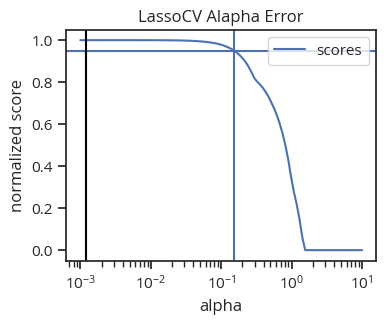

5 model proteins
train score=0.06
test score=0.06


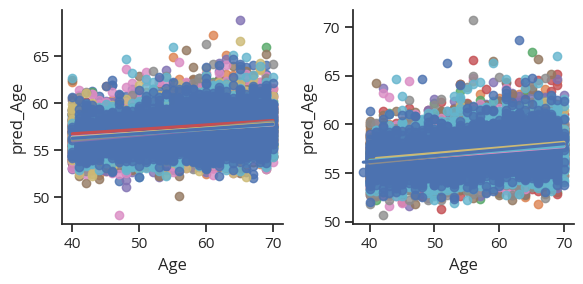

 
Adrenal
alpha: 0.001000
0.10476157527896651


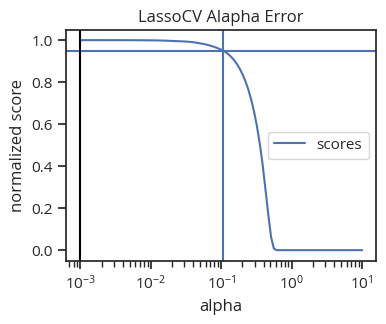

2 model proteins
train score=0.01
test score=-0.0


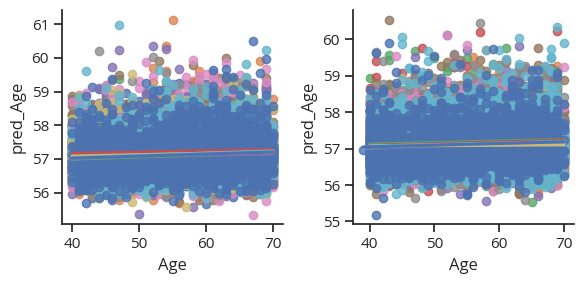

 
Artery
alpha: 0.001000
0.4229242874389499


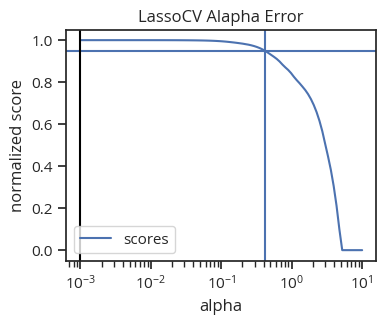

9 model proteins
train score=0.5
test score=0.5


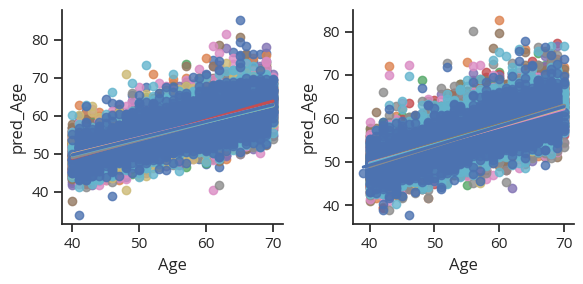

 
Brain
alpha: 0.008498
0.2009233002565048


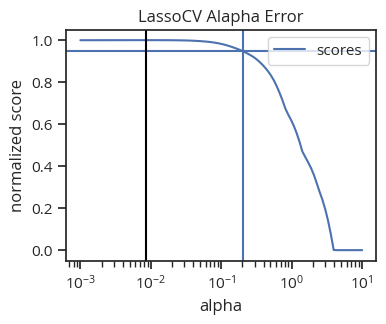

30 model proteins
train score=0.5
test score=0.5


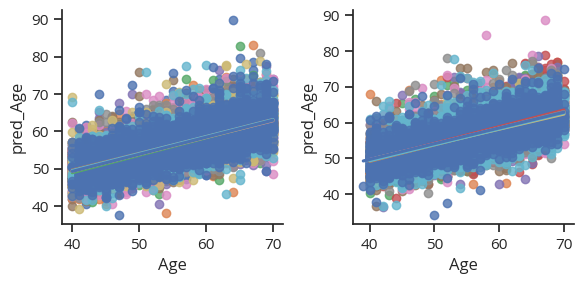

 
Esophagus
alpha: 0.001000
0.26560877829466867


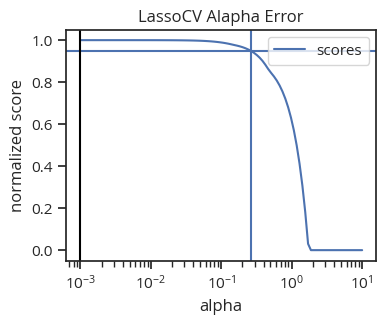

2 model proteins
train score=0.05
test score=0.03


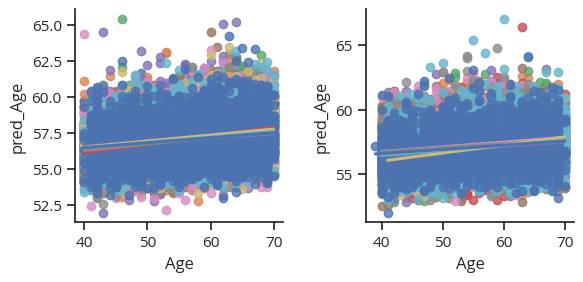

 
Female
alpha: 0.016298
0.5094138014816381


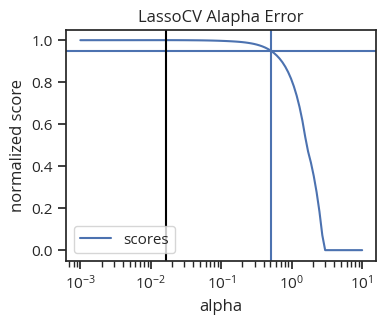

2 model proteins
train score=0.17
test score=0.16


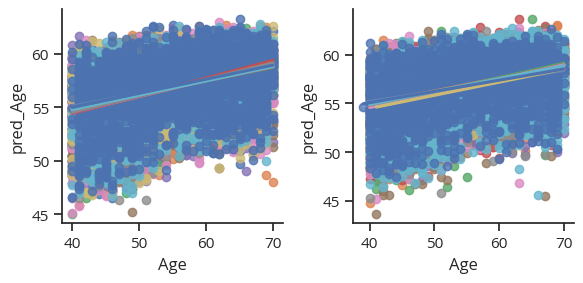

 
Heart
alpha: 0.025950
0.3853528593710531


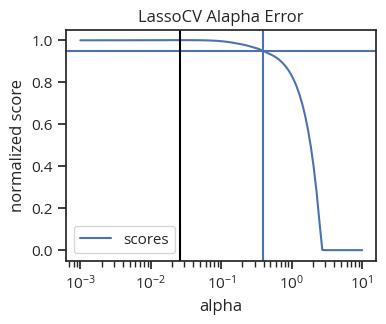

2 model proteins
train score=0.11
test score=0.11


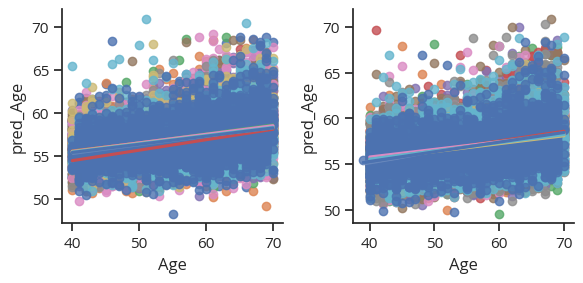

 
Immune
alpha: 0.003678
0.07924828983539177


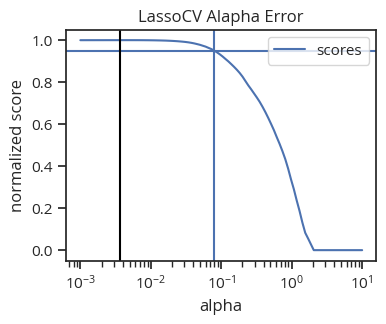

79 model proteins
train score=0.31
test score=0.29


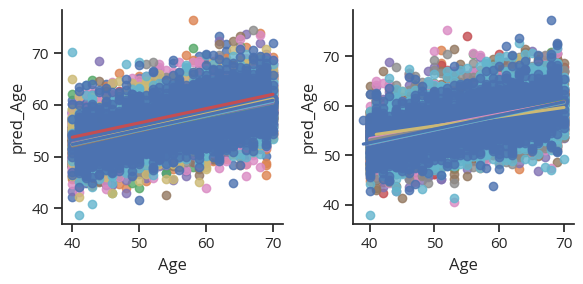

 
Intestine
alpha: 0.005337
0.2009233002565048


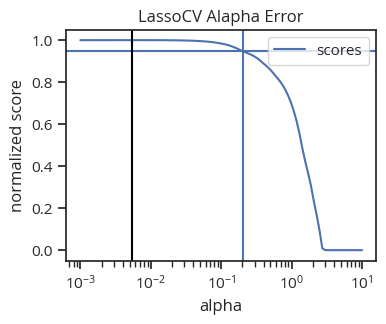

13 model proteins
train score=0.22
test score=0.21


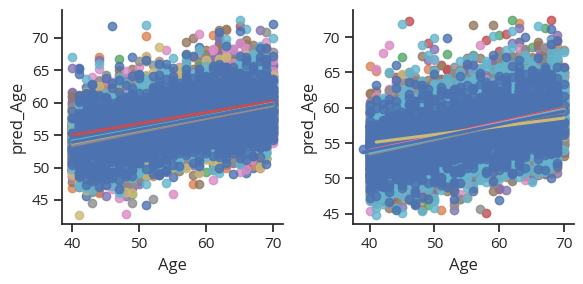

 
Kidney
alpha: 0.014850
0.15199110829529347


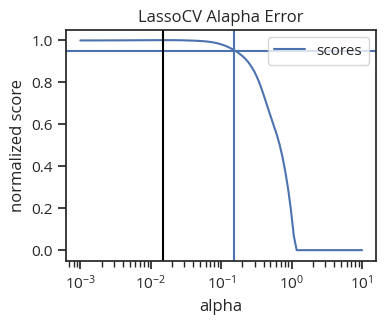

4 model proteins
train score=0.02
test score=0.02


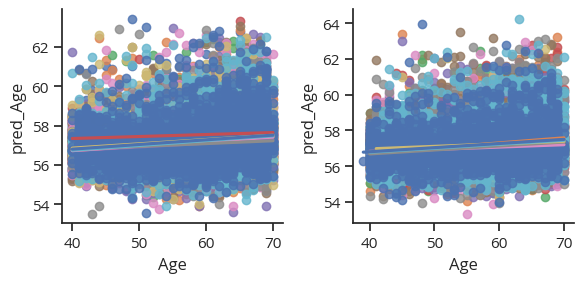

 
Liver
alpha: 0.007055
0.1261856883066021


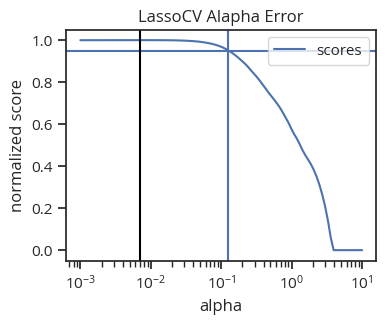

51 model proteins
train score=0.38
test score=0.37


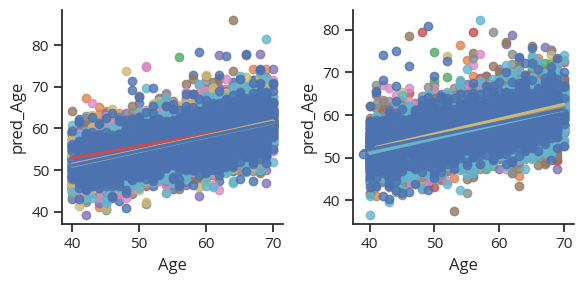

 
Lung
alpha: 0.006428
0.26560877829466867


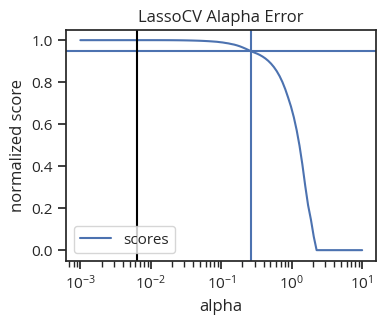

5 model proteins
train score=0.13
test score=0.12


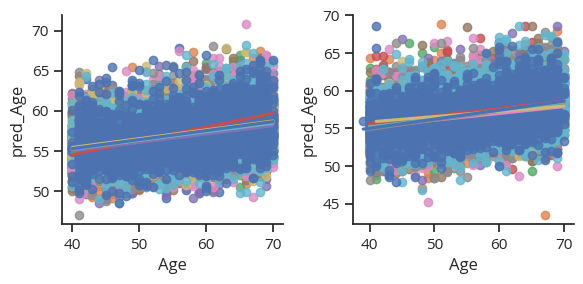

 
Male
alpha: 0.012328
0.1384886371393873


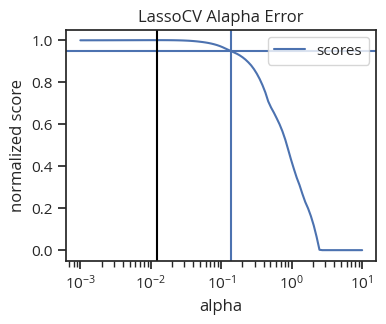

19 model proteins
train score=0.24
test score=0.23


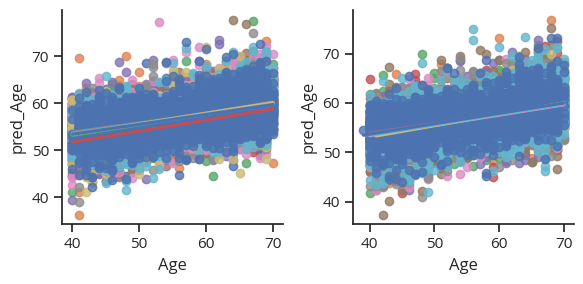

 
Muscle
alpha: 0.011233
0.1668100537200059


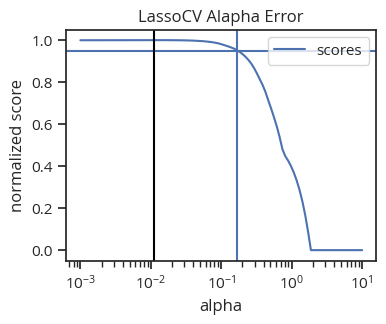

8 model proteins
train score=0.09
test score=0.09


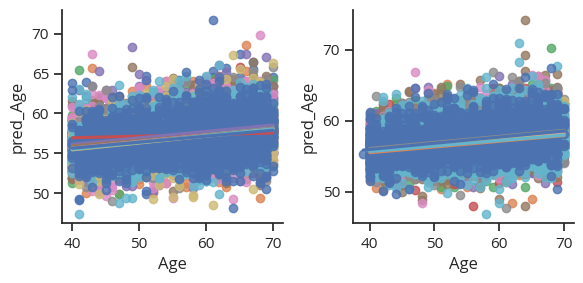

 
Pancreas
alpha: 0.008498
0.11497569953977368


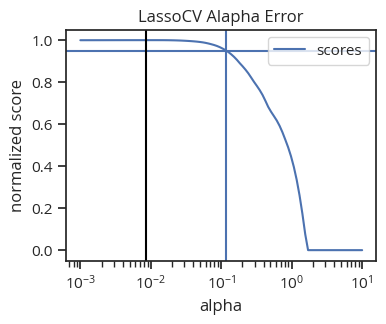

16 model proteins
train score=0.11
test score=0.1


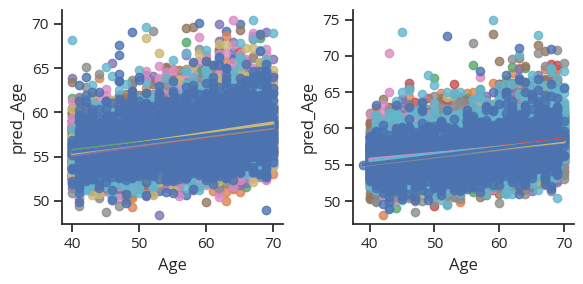

 
Pituitary
alpha: 0.008498
0.29150530628251786


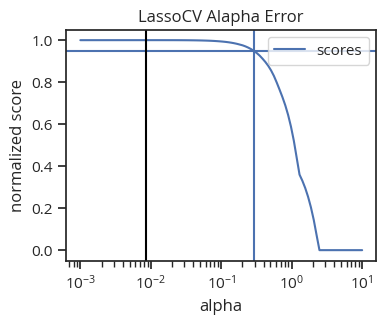

7 model proteins
train score=0.17
test score=0.18


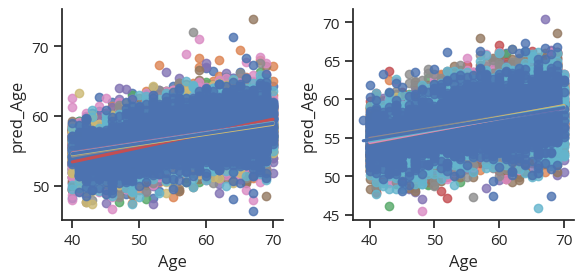

 
Salivary
alpha: 0.001000
0.15199110829529347


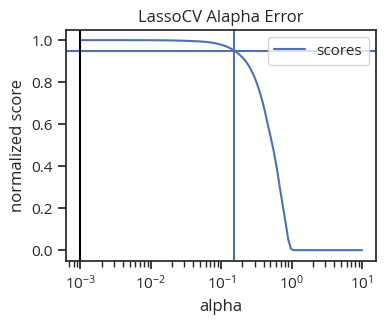

8 model proteins
train score=0.04
test score=0.04


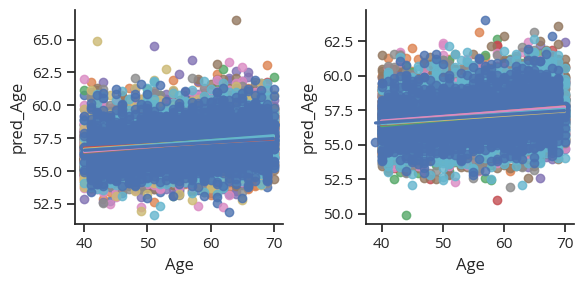

 
Skin
alpha: 0.011233
0.24201282647943834


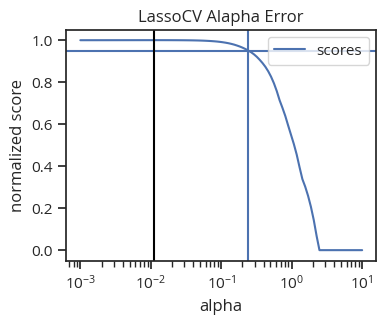

9 model proteins
train score=0.17
test score=0.17


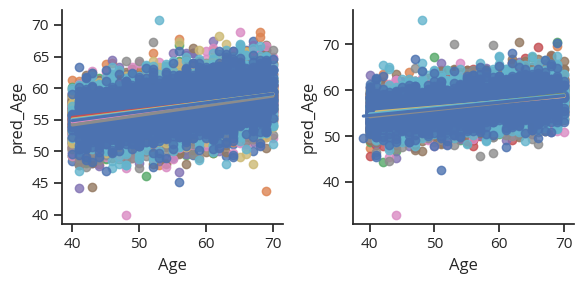

 
Stomach
alpha: 0.009326
0.24201282647943834


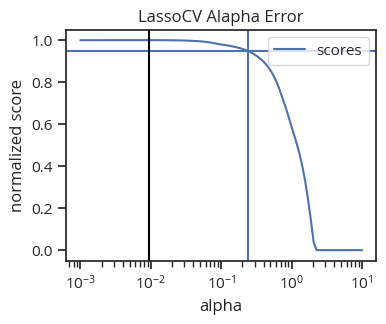

8 model proteins
train score=0.1
test score=0.08


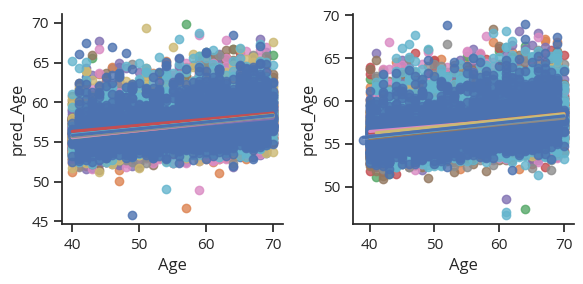

 
Thyroid
alpha: 0.001000
0.1261856883066021


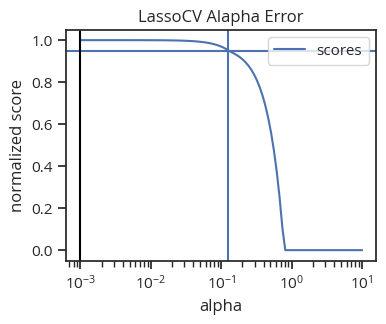

2 model proteins
train score=0.01
test score=0.0


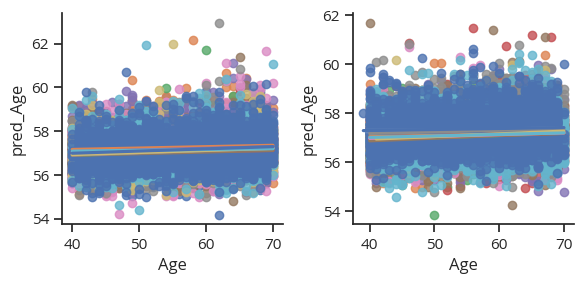

 
Organismal


/scg/apps/software/jupyter/python_3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16088.491591805621, tolerance: 12035.675468885061
  model = cd_fast.enet_coordinate_descent_gram(
/scg/apps/software/jupyter/python_3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12451.564770790792, tolerance: 12150.966278630081
  model = cd_fast.enet_coordinate_descent_gram(
/scg/apps/software/jupyter/python_3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.293e+04, tolerance: 1.515e+04
  model = cd_f

alpha: 0.009326
0.1261856883066021


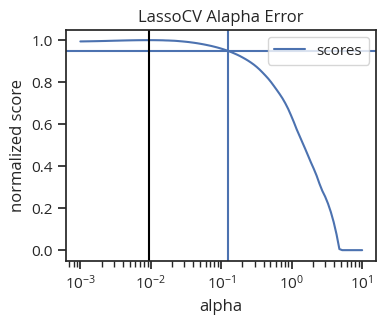

211 model proteins
train score=0.81
test score=0.81


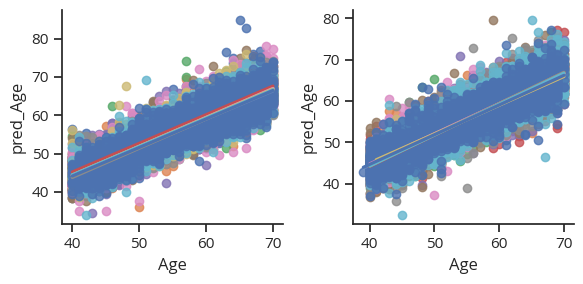

 
Conventional


/scg/apps/software/jupyter/python_3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13057.877865662987, tolerance: 12131.534269122722
  model = cd_fast.enet_coordinate_descent_gram(
/scg/apps/software/jupyter/python_3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16285.7068803882, tolerance: 12035.675468885061
  model = cd_fast.enet_coordinate_descent_gram(
/scg/apps/software/jupyter/python_3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16930.646703252598, tolerance: 12035.675468885061
  model = cd_fast.enet_coordinate_descent_gram(
/scg/apps/software/ju

alpha: 0.010235
0.1384886371393873


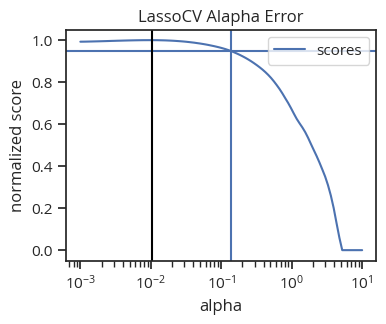

207 model proteins
train score=0.83
test score=0.83


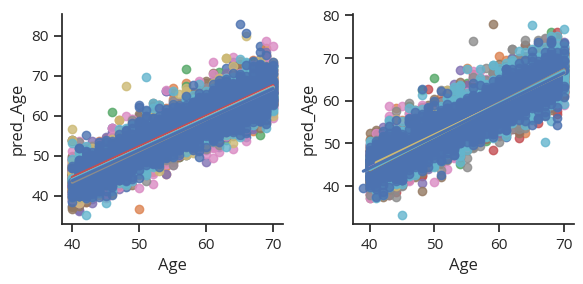

In [27]:
performance_CUTOFF=0.95
tores_pred = []
tores_stats = []
tocoef = []

for tissue,plist in tissue_plist_dict.items():  #tissue:proteinlist dictionary
    print(tissue)
    
    #SETUP
    #metadata for results
    md_train = df_train.iloc[:,:6]
    md_test = df_test.iloc[:,:6]

    #SETUP X - #already scaled, add sex as covariate
    xtraindf = df_train[plist].dropna()
    xtestdf = df_test[plist].dropna()
    
    #SETUP Y
    ytraindf = df_train.loc[xtraindf.index, "Age"]
    ytestdf = df_test.loc[xtestdf.index, "Age"]

    #np
    xtrain = xtraindf.to_numpy()
    xtest = xtestdf.to_numpy()
    ytrain = ytraindf.to_numpy()
    ytest = ytestdf.to_numpy()

    #TRAIN MODEL
    alphas = np.logspace(-3, 1, 100)
    cv=5
    #performance_CUTOFF=0.95
    model = LassoCV(alphas=alphas, cv=cv, tol=0.01,
                    #n_jobs=1
                   )
    model.fit(xtrain, ytrain)
    print('alpha: %f' % model.alpha_)

    best_alpha=Plot_and_pick_alpha(model, performance_CUTOFF, plot=True)   #pick best alpha

    # Retrain 
    lasso = Lasso(alpha=best_alpha, random_state=0, tol=0.01, max_iter=5000)
    lasso.fit(xtrain, ytrain)
    
    # save the model
    pathmodel = '../data_ukb/clocks/UKB_'+tissue+'_aging_model_240829.pkl'
    pickle.dump(lasso, open(pathmodel, 'wb'))
    
    coef_dft = pd.DataFrame(dict(zip(['intercept']+plist, 
                                    [lasso.intercept_]+list(lasso.coef_))),
                           index=[tissue])
    tocoef.append(coef_dft)
    print(str(len([x for x in lasso.coef_ if x!=0]))+" model proteins")

    #TEST AND SAVE
    print("train score="+str(round(lasso.score(xtrain, ytrain),2)))
    print("test score="+str(round(lasso.score(xtest, ytest),2)))
    ypred_train = lasso.predict(xtrain)
    ypred_test = lasso.predict(xtest)

    res_train = md_train.copy()
    res_test = md_test.copy()
    res_train['split']='train'
    res_test['split']='test'        
    res_train["pred_Age"] = ypred_train
    res_test["pred_Age"] = ypred_test
    res = pd.concat([res_train, res_test])
    res['dage']=sm.OLS(res['pred_Age'],sm.add_constant(res[["Age"]])).fit().resid
    res['dage_z']=stats.zscore(res.dage)
    res['tissue']=tissue
    tores_pred.append(res)

    #PLOT
    fig,axs=plt.subplots(1,2,figsize=(6,3))
    for c in set(res_train.Center):
        sns.regplot(res_train.loc[res_train.Center==c], x="Age", y="pred_Age", ax=axs[0])
    for c in set(res_test.Center):
        sns.regplot(res_test.loc[res_test.Center==c], x="Age", y="pred_Age", ax=axs[1])
    sns.despine()
    plt.tight_layout()
    plt.show()
   
    #SAVE STATS
    tores_stats.append([tissue, 
                        lasso.score(xtrain, ytrain),   #r2
                        lasso.score(xtest, ytest),
                        mean_absolute_error(ytrain, ypred_train),  #mae
                        mean_absolute_error(ytest, ypred_test),
                        mean_squared_error(ytrain, ypred_train),  #rmse
                        mean_squared_error(ytest, ypred_test),
                        ])
    print(" ")


In [ ]:
#age prediction results
respred = pd.concat(tores_pred)

#stats
resstat = pd.DataFrame(tores_stats, columns=['tissue', 
                                             'train_r2', 'test_r2',
                                             'train_mae', 'test_mae',
                                             'train_rmse', 'test_rmse']).sort_values("test_r2", ascending=False)
resstat['train_r'] = np.sqrt(resstat.train_r2)
resstat['test_r'] = np.sqrt(resstat.test_r2)

#model coefficients
coefdf = pd.concat(tocoef)
coefdf.index.name='tissue'
